<a href="https://colab.research.google.com/github/neohack22/ebw3nt/blob/main/modelisation/Version_TPU_de_Keras_de_Impl%C3%A9mentationCBOW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyse de Sentiment IMDB: Comparaison PyTorch vs Keras

L'objectif est de mettre en place un classificateur simple pour l'analyse de texte et de sentiment. La tâche est la classification binaire des critiques de films. L'ensemble de données fait partie du jeu de données `imdb`. Vous pouvez trouver l'ensemble de données original sur le [site web d'imdb](https://www.imdb.com/interfaces/) ou une version sur le [site web de kaggle](https://www.kaggle.com/utathya/imdb-review-dataset). Pour cette session de laboratoire, nous utiliserons une version prétraitée.

La feuille de route est :

*   Charger, nettoyer et configurer les données (en pratique, c'est une étape très importante, pour ce laboratoire, nous la sautons).
*   Les rendre adaptées aux modèles PyTorch
*   Définir votre propre modèle
*   Expériences

## Les données

Les jeux de données sont disponibles dans le dépôt cloud. Il y a 2 fichiers, un pour les critiques positives (`imdb.pos`) et un pour les négatives (`imdb.neg`). Il y a 300 000 exemples de chaque classe.

Voici deux fonctions pour charger et nettoyer les données.

In [ ]:
# pytorch

import re
import numpy as np
import torch as th
import torch.autograd as ag
import torch.nn.functional as F
import torch.nn as nn
import random
import math
import pickle
import gzip

th.manual_seed(1) # set the seed

In [ ]:
# KERAS

!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 780.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 110.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 153.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 123.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 22.5 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement gzip (from versions: none)
ERROR: No matching distribution found for gzip


In [ ]:
# keras

import re # Identique pour les expressions régulières
import numpy as np # Identique pour les opérations numériques
import tensorflow as tf # La bibliothèque principale de TensorFlow

from tensorflow import keras # Le module Keras de TensorFlow
from tensorflow.keras import layers # Pour les couches de modèles (Embedding, Dense, etc.)
from tensorflow.keras import models # Pour construire des modèles (Model, Sequential)
from tensorflow.keras import losses # Pour les fonctions de perte
from tensorflow.keras import optimizers # Pour les optimiseurs

import random # Identique pour les opérations aléatoires générales
import math # Identique pour les opérations mathématiques
import pickle # Identique pour la sérialisation des objets Python
import gzip # Identique pour la compression de fichiers

# Définir les graines pour la reproductibilité dans TensorFlow/Keras
tf.random.set_seed(1) # Pour TensorFlow/Keras

np.random.seed(1) # Pour NumPy
random.seed(1) # Pour le module Python random

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


## Chargement des données

Chargez les données :

In [ ]:
# idem

# find the file imdb.pck.gz, and set the next variable accordingly
filename = 'imdb.pck.gz'

# You can download the file with the following line:
! wget "https://drive.google.com/uc?export=download&id=1199vdCPh5jCMBTWTSM9th0wqMNv2KSvA" -O imdb.pck.gz

--2026-02-17 03:25:41--  https://drive.google.com/uc?export=download&id=1199vdCPh5jCMBTWTSM9th0wqMNv2KSvA
Resolving drive.google.com (drive.google.com)... 74.125.195.138, 74.125.195.102, 74.125.195.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.195.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1199vdCPh5jCMBTWTSM9th0wqMNv2KSvA&export=download [following]
--2026-02-17 03:25:41--  https://drive.usercontent.google.com/download?id=1199vdCPh5jCMBTWTSM9th0wqMNv2KSvA&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.195.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1552309 (1.5M) [application/octet-stream]
Saving to: ‘imdb.pck.gz’

imdb.pck.gz         100%[===================>]   1.48M  --.-KB/s   

Ouvrez les données avec Python et vous obtiendrez 3 objets :

*   `texts` : une liste de tenseurs, chaque tenseur représente une séquence de mots à classifier.
*   `labels` : la classe, positive ou négative, du texte correspondant.
*   `lexicon` : un dictionnaire pour mapper les entiers aux mots réels.

In [ ]:
# idem

fp = gzip.open(filename,'rb')
texts , labels, lexicon  = pickle.load(fp)

print(type(texts), type(labels), type(lexicon))
print(texts[0])
print("nb examples : ", len(texts))
VOCAB_SIZE = len(lexicon)
print("Vocab size: ", VOCAB_SIZE)

<class 'list'> <class 'torch.Tensor'> <class 'dict'>
tensor([ 36,  25, 381,  10,  58,  21,  83])
nb examples :  30000
Vocab size:  5002


Le fichier `imdb.pck.gz` est comme une boîte qui contient des objets `torch.Tensor` (des tenseurs PyTorch). Pour ouvrir cette boîte et comprendre ce qu'il y a dedans, Python a besoin de 'savoir parler' PyTorch, d'où l'importation nécessaire de `import torch as th`. Cette étape est une **dépendance du format du fichier source**, et non de votre choix de framework pour la modélisation.

Une fois que ces tenseurs PyTorch sont chargés en mémoire, nous les convertissons immédiatement en tableaux NumPy (`.numpy()`), car NumPy est le langage 'natif' que Keras comprend le mieux pour les données. À partir de là, tout le reste de votre code pourra être purement Keras/TensorFlow.

In [ ]:
# keras

# IMPORTANT : L'import de 'torch' est nécessaire ICI car le fichier 'imdb.pck.gz'
# contient des objets qui ont été SÉRIALISÉS sous forme de tenseurs PyTorch.
# Sans cet import, Python ne peut pas désérialiser correctement ces objets.
import torch as th

print("--- Étape de Chargement et Préparation des Données pour Keras ---")

# 1. Chargement des objets bruts depuis le fichier (Dépend du format de sauvegarde du fichier)
# Les objets récupérés ici seront des torch.Tensor car le fichier a été sauvegardé ainsi.
with gzip.open(filename,'rb') as fp:
    raw_texts_from_file , raw_labels_from_file, lexicon_for_keras  = pickle.load(fp)

print(f"Type des objets après chargement brut : texts est une liste de {type(raw_texts_from_file[0])}")
print(f"Type des objets après chargement brut : labels est de type {type(raw_labels_from_file)}")

# 2. Conversion explicite des tenseurs PyTorch en tableaux NumPy pour Keras
# Keras (basé sur TensorFlow) travaille nativement avec des tableaux NumPy ou des tf.Tensor.
labels_for_keras = raw_labels_from_file.numpy() # Convertir le tenseur PyTorch en tableau NumPy
texts_for_keras = [t.numpy() for t in raw_texts_from_file] # Convertir chaque tenseur de la liste

print("\n--- Objets prêts pour Keras (format NumPy) ---")
print(f"Type final pour Keras : texts_for_keras est une liste de {type(texts_for_keras[0])}")
print(f"Type final pour Keras : labels_for_keras est de type {type(labels_for_keras)}")
print(f"Type de 'lexicon': {type(lexicon_for_keras)}")

print("Exemple de texts_for_keras[0]:", texts_for_keras[0])
print("Nombre d'exemples : ", len(texts_for_keras))
VOCAB_SIZE_KERAS = len(lexicon_for_keras)
print("Taille du vocabulaire: ", VOCAB_SIZE_KERAS)

# Il est recommandé de libérer la mémoire des objets PyTorch bruts si non utilisés
del raw_texts_from_file, raw_labels_from_file


--- Étape de Chargement et Préparation des Données pour Keras ---
Type des objets après chargement brut : texts est une liste de <class 'torch.Tensor'>
Type des objets après chargement brut : labels est de type <class 'torch.Tensor'>

--- Objets prêts pour Keras (format NumPy) ---
Type final pour Keras : texts_for_keras est une liste de <class 'numpy.ndarray'>
Type final pour Keras : labels_for_keras est de type <class 'numpy.ndarray'>
Type de 'lexicon': <class 'dict'>
Exemple de texts_for_keras[0]: [ 36  25 381  10  58  21  83]
Nombre d'exemples :  30000
Taille du vocabulaire:  5002


Notez qu'un nombre réduit de mots est sélectionné pour construire le vocabulaire. Les mots moins fréquents sont écartés et remplacés par une forme spécifique (*unk* pour inconnu).

In [ ]:
# IDEM

for i in range(10):
    print("word of index", i , " : ", lexicon[i])

word of index 0  :  <pad>
word of index 1  :  <unk>
word of index 2  :  !
word of index 3  :  the
word of index 4  :  a
word of index 5  :  of
word of index 6  :  movie
word of index 7  :  and
word of index 8  :  this
word of index 9  :  to


To read the text you can use for example the following code:

In [ ]:
# PYTORCH

def idx2wordlist(idx_array,lexicon):
    l = []
    for i in idx_array:
        l.append(lexicon[i.item()])
    return l
print(texts[0].shape)
print("Some positive reviews")
print("------------")
for i in range(5):
    print(
        idx2wordlist(
            texts[
                i+50],lexicon)) # les critiques positives sont regroupées dans une certaine partie de la liste texts
print("Some negative reviews")
print("------------")
for i in range(5):
    print(
        idx2wordlist(
            texts[
                -i-2000],lexicon)) # les critiques négatives sont stockées à la fin de la liste

print("-----------\nA random sentence: ")
print(idx2wordlist(texts[104],lexicon))

torch.Size([7])
Some positive reviews
------------
['strong', 'drama']
['please', 'remake', 'this', 'movie']
['very', 'funny', '!']
['great', 'series']
['fun', 'movie']
Some negative reviews
------------
['absolute', 'waste', 'of', 'time']
['the', 'worst', 'movie', 'ever', 'made']
['slow', 'motion', 'picture', 'that', 'did', "n't", 'get', 'to', 'the', 'point']
['there', 'are', 'good', 'bad', 'movies', 'and', 'there', 'are', 'bad', 'bad', 'movies', 'this', 'one', 'is', 'a', 'real', 'stinker']
['<unk>', 'so', 'bad', 'its', 'funny']
-----------
A random sentence: 
['you', 'definitely', 'need', 'to', 'see', 'this', 'movie']


In [ ]:
# keras

def idx2wordlist_keras(idx_array, lexicon_keras):
    l = []
    for i in idx_array:
        # .item() fonctionne pour les scalaires NumPy aussi
        l.append(lexicon_keras[i.item()])
    return l

# Assurez-vous que texts_for_keras et lexicon_for_keras sont chargés et prêts
# (comme dans la cellule précédente d'adaptation pour Keras)

print(texts_for_keras[0].shape) # texts_for_keras est une liste de tableaux NumPy, qui ont aussi un .shape
print("Some positive reviews (Keras data)")
print("------------")
for i in range(5):
    print(
        idx2wordlist_keras(
            texts_for_keras[
                i+50], lexicon_for_keras)) # Utilisation de texts_for_keras et lexicon_for_keras
print("Some negative reviews (Keras data)")
print("------------")
for i in range(5):
    print(
        idx2wordlist_keras(
            texts_for_keras[
                -i-2000], lexicon_for_keras)) # Utilisation de texts_for_keras et lexicon_for_keras

print("-----------\nA random sentence (Keras data): ")
print(idx2wordlist_keras(texts_for_keras[104], lexicon_for_keras))


(7,)
Some positive reviews (Keras data)
------------
['strong', 'drama']
['please', 'remake', 'this', 'movie']
['very', 'funny', '!']
['great', 'series']
['fun', 'movie']
Some negative reviews (Keras data)
------------
['absolute', 'waste', 'of', 'time']
['the', 'worst', 'movie', 'ever', 'made']
['slow', 'motion', 'picture', 'that', 'did', "n't", 'get', 'to', 'the', 'point']
['there', 'are', 'good', 'bad', 'movies', 'and', 'there', 'are', 'bad', 'bad', 'movies', 'this', 'one', 'is', 'a', 'real', 'stinker']
['<unk>', 'so', 'bad', 'its', 'funny']
-----------
A random sentence (Keras data): 
['you', 'definitely', 'need', 'to', 'see', 'this', 'movie']


*   **Variables de données** : Les appels à la fonction et les accès aux données utilisent désormais `texts_for_keras` et `lexicon_for_keras`, qui sont les variables que nous avons préparées spécifiquement au format NumPy pour Keras dans la cellule précédente.

En bref, cette partie du code illustre comment les fonctions utilitaires génériques de traitement de données restent souvent les mêmes, peu importe le framework, tant que les formats de données sous-jacents (ici, les tableaux NumPy) sont compatibles.

## Interface données/modèle
En pratique, nous partons de textes bruts et nous devons les convertir en indices de mots. À cette étape, nous pouvons effectuer un prétraitement du texte, une tokenisation et un nettoyage des données. Dans le cas présent, c'est déjà fait. Mais dans la vie réelle, c'est une étape très importante.

L'objectif est d'implémenter un classificateur CBOW (Continuous Bag of Words, ou un sac d'embeddings de mots). Cela signifie que la première couche du modèle gère les embeddings de mots.

Le module Embedding de PyTorch est conçu à cet effet. Ce module attend en entrée un tableau ou une liste d'indices de mots. Pour cette session, l'objectif est de développer rapidement un modèle. L'interface de données est donc plutôt simple. Nous terminons cette section en créant des labels.


## Un premier modèle

Le premier modèle est un CBOW (Continuous Bag of Words). Un texte est représenté comme un ensemble de mots (un sac de caractéristiques binaires) :

- Chaque mot est associé à son embedding.
- Le texte est représenté comme la somme des embeddings de mots impliqués.
- Cette somme d'embeddings est ensuite alimentée à une couche linéaire avec une unité de sortie,
- suivie par l'activation sigmoïde. La sortie du modèle est similaire à une régression logistique.

Maintenant, nous voulons coder cela en PyTorch. Une façon est d'abord d'essayer de construire un tel modèle **étape par étape**, puis de créer une classe pour tout encapsuler dans un **modèle**.

### Construction du modèle, étape par étape

La couche d'entrée du modèle est une couche d'Embedding. Celle-ci est déjà implémentée dans PyTorch.

In [ ]:
# build an Embedding layer in Pytorch
# it is important to understand the parameters given to the constructor !
D = 4
embLayer = th.nn.Embedding(num_embeddings=len(lexicon), embedding_dim=D)
# The dim of 4 is a toy example.
# run forward on some input
inp = texts[104]
embs = embLayer(inp) # embLayer.forward(inp)
# Look at the dimension of i/o
print("The input: ",inp)
print("length: ",len(inp))
print("Embs shape : ",embs.shape)
print(embs)

The input:  tensor([ 21, 316, 320,   9,  59,   8,   6])
length:  7
Embs shape :  torch.Size([7, 4])
tensor([[ 0.6971, -0.9576, -1.0220,  1.3295],
        [ 1.0256,  1.7889, -1.2001,  0.8268],
        [-1.1081,  0.4350, -0.5725, -1.6943],
        [-0.9530, -1.2833, -0.6837,  1.3832],
        [ 0.2081, -0.4403,  1.3717,  0.9725],
        [-0.5415, -1.4216, -0.0367, -1.9919],
        [-1.3417,  0.0124, -1.3485, -0.5739]], grad_fn=<EmbeddingBackward>)


1.  `D = 4`: `D` représente la dimension de l'embedding, c'est-à-dire la taille du vecteur que chaque mot sera transformé. Ici, 4 est choisi comme un exemple simple.

2.  `embLayer = th.nn.Embedding(num_embeddings=len(lexicon), embedding_dim=D)`: C'est la création de la couche d'embedding.
    *   `num_embeddings=len(lexicon)`: C'est le nombre total de mots uniques dans votre vocabulaire. `len(lexicon)` donne la taille du vocabulaire que vous avez chargé précédemment (5002 dans cet exemple). Chaque mot de ce vocabulaire aura un vecteur d'embedding unique.
    *   `embedding_dim=D`: C'est la dimension de chaque vecteur d'embedding. Chaque mot sera représenté par un vecteur de 4 nombres flottants.

3.  `inp = texts[104]`: Cette ligne sélectionne un exemple d'entrée, qui est le 105ème texte (index 104) de votre ensemble de données `texts`. `inp` est un tenseur d'indices de mots, comme `tensor([ 21, 316, 320, 9, 59, 8, 6])`.

4.  `embs = embLayer(inp)`: Cette ligne exécute la propagation avant (`forward pass`) de la couche d'embedding. Elle prend le tenseur d'indices de mots (`inp`) et pour chaque index de mot, elle lui attribue le vecteur d'embedding correspondant de la couche `embLayer`.

5.  Si l'entrée a `N` mots (ici, 7 mots), la sortie `embs` aura la forme `[N, D]`, c'est-à-dire `[7, 4]`. Chaque ligne de ce tenseur de sortie est le vecteur d'embedding de dimension `D` (4) pour le mot correspondant dans l'entrée.

Maintenant, nous voulons compresser le tenseur résultant le long de la dimension temporelle.
Dans le traitement du langage naturel (NLP) et les architectures de réseaux de neurones qui traitent des séquences (comme les RNN, LSTM, Transformers), on parle souvent de la "dimension de la séquence" ou de la "longueur de la séquence" pour désigner cette dimension qui représente la succession des éléments (mots, caractères, tokens) dans le temps ou l'ordre.

Le terme "temporelle" est très pertinent car il évoque l'idée d'une série de points de données qui se suivent, comme une série temporelle. Quand on traite un texte, on le considère comme une séquence d'événements (les mots) qui arrivent dans un certain ordre, d'où l'analogie avec le temps.

Cette dimension dépend des textes d'entrée, alors que nous voulons construire une représentation de taille fixe de la phrase. La somme est une première idée.
En additionnant les vecteurs de chaque mot, vous combinez leurs informations sémantiques. Le vecteur résultant est une sorte de "moyenne" ou de "résumé" de tous les mots présents dans la phrase. Il perd l'information sur l'ordre exact des mots, mais conserve l'information sur les mots qui étaient présents et leurs caractéristiques globales.

In [ ]:
# build an Embedding layer in Keras
# D is the embedding dimension, we use the same as the PyTorch example for direct comparison
D_keras = 4

# lexicon_for_keras et VOCAB_SIZE_KERAS sont définis dans la cellule d'adaptation des données
emb_layer_keras = keras.layers.Embedding(input_dim=VOCAB_SIZE_KERAS, output_dim=D_keras)

# run forward on some input
# texts_for_keras contient déjà les données sous forme de NumPy arrays
inp_keras = texts_for_keras[104]

# Pour Keras, les couches s'attendent généralement à une entrée batchée (même pour un seul exemple)
# Donc, nous ajoutons une dimension de batch (batch_size=1)
inp_keras_batched = np.expand_dims(inp_keras, axis=0)

# Effectuer le passage avant (forward pass)
embs_keras_batched = emb_layer_keras(inp_keras_batched) # emb_layer_keras.call(inp_keras_batched)

# Retirer la dimension du batch pour l'affichage, pour comparer directement avec la sortie PyTorch originale
embs_keras = tf.squeeze(embs_keras_batched, axis=0)

# Look at the dimension of i/o
print("The input (NumPy): ", inp_keras)
print("length: ", len(inp_keras))
print("Embs shape (Keras) : ", embs_keras.shape)
print(embs_keras)


The input (NumPy):  [ 21 316 320   9  59   8   6]
length:  7
Embs shape (Keras) :  (7, 4)
tf.Tensor(
[[ 0.03792583  0.02277488  0.00360626 -0.04416872]
 [ 0.00883637  0.0329697   0.00840785 -0.04305023]
 [-0.01492629 -0.01901884 -0.02802038 -0.03017336]
 [-0.0082077   0.00786048  0.03529478  0.02130631]
 [ 0.00259622 -0.02487297 -0.01616706  0.02925593]
 [ 0.00261338 -0.04302381 -0.04602699 -0.01775904]
 [ 0.02076641 -0.02659606  0.038443   -0.02329419]], shape=(7, 4), dtype=float32)


1.  **Importations** :
    *   PyTorch : `th.nn.Embedding`
    *   Keras : `tf.keras.layers.Embedding`

2.  **Paramètres du Constructeur** :
    *   PyTorch : `num_embeddings` (taille du vocabulaire), `embedding_dim` (dimension de l'embedding).
    *   Keras : `input_dim` (taille du vocabulaire), `output_dim` (dimension de l'embedding).
    *   Les concepts sont les mêmes, juste les noms de paramètres changent.

3.  **Taille du Vocabulaire (`len(lexicon)`)** :
    *   Nous utilisons `VOCAB_SIZE_KERAS` qui a été calculé à partir de `lexicon_for_keras`, notre version du lexique préparée pour Keras.

4.  **Préparation de l'entrée** :
    *   PyTorch : Prend directement un tenseur d'indices (`inp = texts[104]`).
    *   Keras : Les couches Keras sont conçues pour traiter des *lots* de données. Même si vous n'avez qu'un seul exemple (`inp_keras`), vous devez généralement ajouter une dimension de lot. `np.expand_dims(inp_keras, axis=0)` transforme l'entrée de `(sequence_length,)` à `(1, sequence_length)`.

5.  **Passage Avant (Forward Pass)** :
    *   PyTorch : `embs = embLayer(inp)` (l'objet `embLayer` est *callable*).
    *   Keras : `embs_keras_batched = emb_layer_keras(inp_keras_batched)` (l'objet `emb_layer_keras` est également *callable*). La méthode `call` est appelée implicitement.

6.  **Forme de la Sortie** :
    *   PyTorch : Si l'entrée est `(sequence_length,)`, la sortie est `(sequence_length, embedding_dim)`.
    *   Keras : Si l'entrée est `(batch_size, sequence_length)`, la sortie est `(batch_size, sequence_length, embedding_dim)`. C'est pourquoi nous utilisons `tf.squeeze(embs_keras_batched, axis=0)` pour retirer la dimension de batch `(1,)` et obtenir `(sequence_length, embedding_dim)` pour une comparaison directe.

In [ ]:
# pytorch

## compute the sum of out to create a vector of size "embedding_dim".
## Of course it will be a tensor with one dimension set to "embedding_dim".
sumOfEmbs = embs.sum(dim=1)
print(sumOfEmbs.shape) # check the shape
sumOfEmbs = embs.sum(dim=0)
print(sumOfEmbs.shape) # check the shape

torch.Size([7])
torch.Size([4])


In [ ]:
# keras

# Rappel: embs_keras a la forme (sequence_length, D_keras)
# Pour le CBOW, on somme généralement le long de la dimension de la séquence pour obtenir un vecteur unique
# de taille D_keras.

# Dans TensorFlow/Keras, 'tf.reduce_sum' est l'équivalent de '.sum()'
# et l'argument 'axis' est utilisé pour spécifier la dimension à sommer.

# La première tentative du code PyTorch était sum(dim=1), ce qui aurait réduit la dimension des embeddings
# à une seule valeur par mot. Si embs_keras est de forme (N, D), sum(axis=1) donnerait (N,).
# sum_along_embedding_dim_keras = tf.reduce_sum(embs_keras, axis=1)
# print("Shape after summing along embedding dimension (axis=1): ", sum_along_embedding_dim_keras.shape)

# Pour le CBOW, l'objectif est de sommer les embeddings de tous les mots pour obtenir un seul vecteur
# de la taille de la dimension d'embedding. Cela correspond à sum(dim=0) dans PyTorch pour un tenseur (N,D).
sumOfEmbs_keras = tf.reduce_sum(embs_keras, axis=0)

print("Embs shape (Keras): ", embs_keras.shape)
print("Shape after summing along sequence dimension (axis=0): ", sumOfEmbs_keras.shape)
print("Somme des embeddings (Keras):")
print(sumOfEmbs_keras)


Embs shape (Keras):  (7, 4)
Shape after summing along sequence dimension (axis=0):  (4,)
Somme des embeddings (Keras):
tf.Tensor([ 0.04960421 -0.04990663 -0.00446253 -0.10788331], shape=(4,), dtype=float32)


1.  **Fonction de Somme** :
    *   PyTorch : La méthode `.sum()` est appelée directement sur le tenseur (`embs.sum(dim=X)`).
    *   Keras/TensorFlow : La fonction `tf.reduce_sum(tensor, axis=X)` est utilisée. Elle est plus générale et permet de sommer le long d'un ou plusieurs axes.

2.  **Spécification de la Dimension** :
    *   PyTorch : L'argument `dim` spécifie la dimension le long de laquelle la somme est effectuée (par exemple, `dim=0` pour le premier axe, `dim=1` pour le deuxième, etc.).
    *   Keras/TensorFlow : L'argument `axis` spécifie l'axe ou les axes le long desquels la somme est effectuée. `axis=0` est équivalent à `dim=0`, `axis=1` à `dim=1`.

3.  **L'objectif du CBOW** :
    *   Dans le contexte du Continuous Bag of Words (CBOW), l'objectif est de représenter une séquence de mots par un *seul vecteur* qui est la somme (ou la moyenne) de leurs embeddings individuels. Pour un tenseur d'embeddings de forme `(longueur_sequence, dimension_embedding)`, cela signifie sommer les embeddings sur la dimension `longueur_sequence`.
    *   La ligne `sumOfEmbs_keras = tf.reduce_sum(embs_keras, axis=0)` réalise exactement cela : elle somme les vecteurs d'embedding de chaque mot (`embs_keras` est de forme `[7, 4]`) le long du premier axe (l'axe des mots), ce qui donne un vecteur de forme `[4]` (la dimension de l'embedding).

En bref, la fonctionnalité est la même, seule la syntaxe change de la méthode `.sum()` de PyTorch à la fonction `tf.reduce_sum()` de TensorFlow, avec `dim` devenant `axis`.

La couche finale est une transformation linéaire : en entrée, nous avons un vecteur de taille embedding_dim et 1 en sortie. Codons cette transformation et vérifions la forme du résultat final.

In [ ]:
# pytorch

# Compute out, after you created the Linear layer
th.manual_seed(12) # set the seed
W  = th.nn.Linear(in_features=D, out_features=1) # création de la couche linéaire.

out_activation = th.nn.Sigmoid()
out= out_activation( # Le résultat de la couche linéaire est passé à la fonction Sigmoïde
    W(sumOfEmbs)) # notre représentation fixe de la phrase est passée à la couche linéaire W
print(out.shape,out)

W  = th.nn.Linear(in_features=D, out_features=1)
out_activation = th.nn.Sigmoid()
out= out_activation(W(sumOfEmbs))
print(out.shape,out)

torch.Size([1]) tensor([0.6601], grad_fn=<SigmoidBackward>)
torch.Size([1]) tensor([0.8424], grad_fn=<SigmoidBackward>)


La fonction Sigmoïde prend n'importe quelle valeur réelle et la compresse dans l'intervalle [0, 1]. Dans un contexte de classification binaire, cela peut être interprété comme la probabilité que l'entrée appartienne à la classe positive.

In [ ]:
# keras

# Définir la graine pour la reproductibilité dans TensorFlow/Keras
tf.random.set_seed(12) # Équivalent de th.manual_seed(12)

# D_keras est la dimension d'embedding définie précédemment (e.g., 4)
# sumOfEmbs_keras est le vecteur sommé des embeddings, de forme (D_keras,)

# Crée la couche Dense (équivalent de nn.Linear) avec une activation sigmoïde
# On peut définir l'activation directement dans la couche Dense pour simplifier
W_keras = keras.layers.Dense(units=1, activation='sigmoid', input_shape=(D_keras,))

# Pour le passage avant, Keras s'attend à une entrée batchée, même pour un seul exemple.
# sumOfEmbs_keras est de forme (D_keras,), nous devons ajouter une dimension de batch.
sumOfEmbs_keras_batched = tf.expand_dims(sumOfEmbs_keras, axis=0) # forme (1, D_keras)

# Effectuer le passage avant (forward pass)
out_keras = W_keras(sumOfEmbs_keras_batched)

# La sortie sera de forme (1, 1), car nous avons une dimension de batch de 1 et 1 unité de sortie.
# Pour comparer au PyTorch qui était (1,), on peut squeeze la dimension du batch.
print(out_keras.shape, tf.squeeze(out_keras))

# Si vous voulez l'implémentation étape par étape (Dense puis Sigmoid séparément):
# W_keras_no_act = keras.layers.Dense(units=1, input_shape=(D_keras,))
# out_activation_keras = tf.keras.activations.sigmoid
# out_keras_step_by_step = out_activation_keras(W_keras_no_act(sumOfEmbs_keras_batched))
# print(out_keras_step_by_step.shape, tf.squeeze(out_keras_step_by_step))


(1, 1) tf.Tensor(0.50064105, shape=(), dtype=float32)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1.  **Graine aléatoire** :
    *   PyTorch : `th.manual_seed(12)`
    *   Keras/TensorFlow : `tf.random.set_seed(12)`. Il est important de la définir pour s'assurer que l'initialisation des poids de la couche `Dense` est reproductible.

2.  **Couche Linéaire (Dense)** :
    *   PyTorch : `th.nn.Linear(in_features=D, out_features=1)`.
    *   Keras : `keras.layers.Dense(units=1, input_shape=(D_keras,))`. Le paramètre `units` est équivalent à `out_features`, et `input_shape` est souvent requis (ou déduit lors du premier appel) pour définir la forme d'entrée attendue. `in_features` est implicitement défini par `input_shape`.

3.  **Fonction d'Activation Sigmoïde** :
    *   PyTorch : `th.nn.Sigmoid()` appliquée séparément, comme `out_activation(W(sumOfEmbs))`. Les fonctions d'activation peuvent être des couches (`nn.Sigmoid`) ou des fonctions (`F.sigmoid`).
    *   Keras : Vous pouvez intégrer l'activation directement dans la couche `Dense` avec l'argument `activation='sigmoid'`, ce qui est la pratique courante et plus concise (`keras.layers.Dense(..., activation='sigmoid')`). Alternativement, vous pourriez appliquer `tf.keras.activations.sigmoid` après la couche `Dense` comme une fonction séparée.

4.  **Gestion des dimensions (batch)** :
    *   PyTorch : Pour un seul exemple, si `sumOfEmbs` est de forme `(D,)`, `W(sumOfEmbs)` fonctionne souvent directement et produit `(1,)`.
    *   Keras : Les couches Keras s'attendent presque toujours à une entrée `batchée`. Si `sumOfEmbs_keras` est de forme `(D_keras,)`, il faut ajouter une dimension de batch (`tf.expand_dims(sumOfEmbs_keras, axis=0)` pour obtenir `(1, D_keras)`). La sortie sera alors de forme `(1, 1)`. Pour une comparaison directe avec la sortie PyTorch `(1,)`, `tf.squeeze` est utilisé pour retirer la dimension de batch de taille 1.

En résumé, les concepts sont les mêmes mais la syntaxe et la gestion des dimensions (batching) diffèrent notablement entre les deux frameworks.

Ce segment de code finalise la construction de la prédiction du modèle en prenant la représentation de la phrase (le vecteur d'embeddings sommé) et en la transformant en une probabilité de classification.

*   **`W_keras = keras.layers.Dense(units=1, activation='sigmoid', input_shape=(D_keras,))`**
    *   **Action**: Cette ligne définit la couche de sortie du modèle.
    *   **`keras.layers.Dense`**: C'est la couche entièrement connectée de Keras, équivalente à `nn.Linear` en PyTorch. Elle effectue une transformation linéaire sur ses entrées.
    *   **`units=1`**: Indique que cette couche produira une seule valeur en sortie. Pour notre tâche de classification binaire (positive ou négative), cette unique valeur représente la probabilité d'appartenir à la classe positive.
    *   **`activation='sigmoid'`**: Applique la fonction d'activation sigmoïde à la sortie de la transformation linéaire. La sigmoïde 'écrase' n'importe quelle valeur réelle entre 0 et 1, ce qui permet d'interpréter la sortie directement comme une probabilité.
    *   **`input_shape=(D_keras,)`**: Spécifie la forme attendue pour l'entrée de cette couche. `D_keras` est la dimension des embeddings (par exemple, 4). Cela signifie que la couche `Dense` attend un vecteur de `D_keras` éléments par exemple.

*   **`sumOfEmbs_keras_batched = tf.expand_dims(sumOfEmbs_keras, axis=0)`**
    *   **Action**: Prépare l'entrée `sumOfEmbs_keras` pour être traitée par la couche `Dense`, en ajoutant une dimension de batch.
    *   **Contexte Keras**: Les modèles Keras sont conçus pour travailler avec des *batchs* (lots) de données. Même lorsque vous ne traitez qu'un seul exemple (comme c'est le cas ici pour `sumOfEmbs_keras`), Keras s'attend à ce que l'entrée ait une dimension pour le batch.
    *   **Transformation**: Si `sumOfEmbs_keras` a une forme `(D_keras,)` (par exemple, `(4,)`), `tf.expand_dims(..., axis=0)` le transforme en `(1, D_keras)` (par exemple, `(1, 4)`). Le `1` représente la taille du batch (un seul exemple), et `D_keras` est la dimension de la caractéristique de cet exemple.

*   **`out_keras = W_keras(sumOfEmbs_keras_batched)`**
    *   **Action**: Exécute le passage avant (forward pass) à travers la couche de sortie que nous avons définie.
    *   **Déroulement**: La `couche W_keras` prend `sumOfEmbs_keras_batched` (notre vecteur de phrase batché) comme entrée. Elle calcule d'abord le produit matriciel des entrées avec ses poids internes, ajoute son biais, puis applique la fonction sigmoïde. Le résultat, `out_keras`, est un tenseur contenant la probabilité prédite par le modèle.

*   **`print(out_keras.shape, tf.squeeze(out_keras))`**
    *   **Action**: Affiche la forme du tenseur de sortie et sa valeur réelle après avoir supprimé les dimensions superflues.
    *   **`out_keras.shape`**: La sortie directe de `W_keras` aura une forme `(1, 1)`. Le premier `1` est la dimension de batch que nous avons ajoutée, et le second `1` est dû au fait que `units=1` dans la couche `Dense`.
    *   **`tf.squeeze(out_keras)`**: Cette fonction est utilisée pour supprimer toutes les dimensions de taille 1 du tenseur. Dans ce cas, elle transforme le tenseur de forme `(1, 1)` en un tenseur scalaire (ou de forme `()` si c'est une valeur unique) ou `(1,)`, ce qui permet d'obtenir la valeur de probabilité unique de manière plus concise et comparable à la sortie de PyTorch pour un seul exemple.

En somme, ces étapes traduisent la représentation vectorielle d'une phrase en une unique probabilité binaire, indiquant la prédiction du modèle quant à la classe de la revue.

### Encapsuler le tout dans un module

Pour écrire votre propre module, héritez de la classe *Module*.

In [ ]:
# pytorch

class CBOW_classifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim):
        super(CBOW_classifier, self).__init__()
        self.emb = nn.Embedding( # crée la couche d'embedding
            vocab_size, embedding_dim) # Cette couche prendra des indices de mots en entrée et retournera leurs vecteurs d'embedding correspondants
        self.lin = nn.Linear( # crée la couche linéaire
            embedding_dim, 1)

    def forward( # comment une entrée (inp) est transformée pour produire la sortie du modèle
        self, inp):
        return th.sigmoid(
            self.lin(
                self.emb( # convertit chaque indice de mot en son vecteur d'embedding
                    inp).sum(
                        dim=0)))


In [ ]:
# keras

class CBOW_classifier_keras(keras.Model):

    def __init__(self, vocab_size, embedding_dim):
        super(CBOW_classifier_keras, self).__init__()
        # Crée la couche d'embedding
        # input_dim correspond à vocab_size, output_dim à embedding_dim
        self.emb = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)
        # Crée la couche linéaire (Dense)
        # units correspond à la taille de sortie (ici 1 pour classification binaire)
        self.lin = layers.Dense(units=1)

    def call(self, inputs): # La méthode 'call' est l'équivalent de 'forward' en PyTorch
        # inputs aura la forme (batch_size, sequence_length)

        # 1. Convertit chaque indice de mot en son vecteur d'embedding
        # embeddings aura la forme (batch_size, sequence_length, embedding_dim)
        embeddings = self.emb(inputs)

        # 2. Somme les embeddings le long de la dimension de la séquence (axis=1)
        # Cela crée un vecteur de taille (batch_size, embedding_dim) pour chaque exemple
        sum_of_embs = tf.reduce_sum(embeddings, axis=1)

        # 3. Passe la représentation fixe de la phrase à la couche linéaire
        linear_output = self.lin(sum_of_embs)

        # 4. Applique l'activation sigmoïde pour obtenir une probabilité entre 0 et 1
        return tf.sigmoid(linear_output)

# Exemple d'utilisation (pour tester le forward pass)
# tf.random.set_seed(1) # Pour la reproductibilité, déjà fait en début de notebook
# D_keras = 10 # Utilisons la même dimension d'embedding que l'exemple PyTorch

# classifier_keras = CBOW_classifier_keras(vocab_size=VOCAB_SIZE_KERAS, embedding_dim=D_keras)

# # Keras attend des entrées batchées, même pour un seul exemple
# # texts_for_keras[0] est de forme (sequence_length,)
# single_input_batch = tf.expand_dims(texts_for_keras[0], axis=0) # Forme (1, sequence_length)

# print("Prédiction Keras pour le premier exemple :", classifier_keras(single_input_batch))
# print("Vrai label Keras pour le premier exemple :", labels_for_keras[0])


1.  **Héritage de la Classe** :
    *   PyTorch : Votre modèle hérite de `th.nn.Module`.
    *   Keras : Votre modèle hérite de `tf.keras.Model` pour des modèles plus complexes ou de `tf.keras.Sequential` pour des modèles séquentiels simples. `tf.keras.Model` est préférable ici pour définir des couches et un `call` personnalisé.

2.  **Constructeur (`__init__`)** :
    *   PyTorch : Les couches sont définies comme `self.emb = nn.Embedding(...)` et `self.lin = nn.Linear(...)`.
    *   Keras : Les couches sont définies de manière similaire : `self.emb = layers.Embedding(...)` et `self.lin = layers.Dense(...)`. Les paramètres `input_dim`/`output_dim` pour `Embedding` et `units` pour `Dense` sont les équivalents de `num_embeddings`/`embedding_dim` et de la taille de sortie de `nn.Linear`.

3.  **Passage Avant (`forward` vs `call`)** : Quand vous faites classifier_keras(single_input_batch), c'est la méthode __call__ de la classe tf.keras.Model qui est exécutée.
Cette méthode __call__ s'attend à trouver et à exécuter votre méthode call() pour définir le flux de données à travers votre modèle. Si vous la renommez, Keras ne saura pas comment exécuter votre logique de calcul.
    *   PyTorch : La logique de passage avant est implémentée dans la méthode `forward(self, inp)`.
    *   Keras : La logique de passage avant est implémentée dans la méthode `call(self, inputs)`. C'est là que le flux de données à travers les couches est défini.

4.  **Gestion des Entrées (Batching)** :
    *   PyTorch : Le `forward` est souvent flexible et peut accepter un seul exemple ou un batch. Si `inp` est de forme `(sequence_length,)`, `emb(inp)` retourne `(sequence_length, embedding_dim)`. La somme est alors `sum(dim=0)`.
    *   Keras : La méthode `call` de `tf.keras.Model` s'attend *toujours* à des entrées batchées. Donc, `inputs` aura la forme `(batch_size, sequence_length)`. Après l'embedding, `embeddings` aura la forme `(batch_size, sequence_length, embedding_dim)`.
    *   Pour sommer les embeddings de mots dans chaque séquence (pour chaque élément du batch), nous utilisons `tf.reduce_sum(embeddings, axis=1)`. Notez que l'`axis` est `1` ici car l'axe `0` est la dimension du batch et l'axe `1` est la dimension de la séquence. Le résultat sera de forme `(batch_size, embedding_dim)`.

5.  **Fonction d'Activation** :
    *   PyTorch : `th.sigmoid(...)` est appliqué à la sortie de la couche linéaire.
    *   Keras : `tf.sigmoid(...)` est l'équivalent. Vous pouvez aussi l'intégrer directement dans la couche `Dense` comme `layers.Dense(units=1, activation='sigmoid')` pour un code plus concis (ce que j'ai fait dans l'exemple étape par étape précédent).

En résumé, les concepts de couches d'embedding, couches linéaires et fonctions d'activation sont les mêmes, mais la syntaxe de leur définition et surtout la manière de gérer le flux de données (particulièrement l'attente d'entrées batchées et la spécification des axes pour les opérations) diffèrent entre PyTorch et Keras.

Cette classe hérite de *Module*. Ces deux méthodes sont obligatoires. Le constructeur construit un modèle avec ses paramètres initialisés. Le *forward* est pour l'inférence.

Le tenseur d'embeddings résultant de l'étape précédente (qui a la forme [nombre_de_mots, embedding_dim]) est ensuite sommé le long de la dimension 0 (la dimension des mots). Cela produit un seul vecteur de taille embedding_dim, qui représente la phrase entière (le principe du Bag of Words).

Dans PyTorch, un modèle prend des *Tensors (variables)* en entrée et renvoie des *Tensors (variables)*. La sortie est comparée à la vérité terrain par la fonction de perte.

Prenons un exemple d'entraînement et vérifions si le passage avant (forward pass) est correct. Le résultat devrait être un *FloatTensor* avec une seule valeur : le score entre 0 et 1 attribué par le modèle à l'exemple.

In [ ]:
#pytorch

classifier = CBOW_classifier(
    vocab_size=len(
        lexicon),embedding_dim=10) # hyperparamètre important que vous pourrez ajuster
print(classifier(texts[0]))
print(labels[0]) # vrai label

tensor([0.6236], grad_fn=<SigmoidBackward>)
tensor(0.)


Cette valeur est la prédiction du modèle pour le texte texts[0], représentant la probabilité que ce texte soit une critique positive. Une valeur proche de 1 indique une forte probabilité d'être positif, et une valeur proche de 0 indique une forte probabilité d'être négatif.

In [ ]:
# PYTORCH

print(classifier.forward(texts[0]))

tensor([0.6236], grad_fn=<SigmoidBackward>)


classifier(texts[0]) est une syntaxe raccourcie et préférée pour classifier.forward(texts[0]) dans PyTorch

In [ ]:
# Créer une instance du classificateur CBOW pour Keras

# Nous utilisons VOCAB_SIZE_KERAS et une dimension d'embedding de 10, comme dans l'exemple PyTorch.
D_keras_model = 10 # Dimension de l'embedding pour le modèle
classifier_keras = CBOW_classifier_keras(
    vocab_size=VOCAB_SIZE_KERAS,
    embedding_dim=D_keras_model)

# Obtenir une entrée unique pour la prédiction (ici, le premier texte)
# Keras attend des entrées batchées, même pour un seul exemple.
# texts_for_keras[0] est de forme (sequence_length,)
single_input_batch = tf.expand_dims(texts_for_keras[0], axis=0) # Convertir en forme (1, sequence_length)

# Obtenir la prédiction du modèle Keras
keras_prediction = classifier_keras(single_input_batch)

# Afficher la prédiction et le vrai label
# La prédiction Keras sera de forme (1, 1), donc nous utilisons tf.squeeze pour obtenir un scalaire.
print("Prédiction Keras pour texts_for_keras[0]:", tf.squeeze(keras_prediction))
print("Vrai label pour labels_for_keras[0]:", labels_for_keras[0])


Prédiction Keras pour texts_for_keras[0]: tf.Tensor(0.48061645, shape=(), dtype=float32)
Vrai label pour labels_for_keras[0]: 0.0


1.  **Instantiation du modèle** :
    *   PyTorch : `classifier = CBOW_classifier(vocab_size=len(lexicon), embedding_dim=10)`
    *   Keras : `classifier_keras = CBOW_classifier_keras(vocab_size=VOCAB_SIZE_KERAS, embedding_dim=D_keras_model)`
    *   Le principe est le même : instancier la classe du modèle avec la taille du vocabulaire et la dimension d'embedding. Nous utilisons `VOCAB_SIZE_KERAS` et avons défini une variable `D_keras_model` pour la dimension d'embedding.

2.  **Prédiction (appel `forward`/`call`)** :
    *   PyTorch : `print(classifier(texts[0]))` appelle implicitement la méthode `forward` de la classe `CBOW_classifier`.
    *   Keras : `keras_prediction = classifier_keras(single_input_batch)` appelle implicitement la méthode `call` de la classe `CBOW_classifier_keras`.

3.  **Préparation de l'entrée** :
    *   **C'est une différence fondamentale**. PyTorch peut souvent gérer un seul exemple (`texts[0]`) directement. Son `forward` est conçu pour traiter des tenseurs non batchés s'il y a lieu.
    *   Keras (et TensorFlow en général) est fortement orienté vers le traitement par lots. Ainsi, `texts_for_keras[0]` qui est un tableau NumPy de forme `(longueur_sequence,)` doit être transformé en un batch de taille 1, `(1, longueur_sequence)`, à l'aide de `tf.expand_dims(..., axis=0)`.

4.  **Accès au vrai label** :
    *   PyTorch : `print(labels[0])` accède à la première valeur du tenseur `labels`.
    *   Keras : `print(labels_for_keras[0])` accède à la première valeur du tableau NumPy `labels_for_keras`.

5.  **Forme de la sortie** :
    *   La sortie du modèle PyTorch (`classifier(texts[0])`) était un tenseur scalaire `tensor([0.6236])` (forme `(1,)`).
    *   La sortie du modèle Keras (`keras_prediction`) sera un tenseur de forme `(1, 1)` (batch de 1, 1 unité de sortie). Pour obtenir une valeur scalaire pour la comparaison ou l'affichage, nous utilisons `tf.squeeze(keras_prediction)` qui supprime les dimensions de taille 1.

En résumé, les concepts sont les mêmes, mais la gestion explicite des batchs est une étape cruciale en Keras pour le passage avant d'un modèle.

### Fonction objectif
La fonction de perte (ou fonction objectif) est adaptée au modèle et à la tâche.

- Lisez la documentation du module **nn** : http://pytorch.org/docs/master/nn.html.
- Dans notre cas, deux fonctions de perte peuvent être utilisées : *BCELoss* et *BCEWithLogitsLoss*. Comparez-les et faites votre choix.
- Compte tenu de ce choix, vous pourriez vouloir modifier la classe *CBOW_Classifier*.

In [ ]:
# pytorch

## define de training function
loss_fn = nn.BCELoss()


In [ ]:
# keras

# Définition de la fonction de perte pour Keras
# BinaryCrossentropy est l'équivalent direct de BCELoss pour la classification binaire.
loss_fn_keras = keras.losses.BinaryCrossentropy()

print("Fonction de perte Keras définie:", loss_fn_keras)


Fonction de perte Keras définie: <LossFunctionWrapper(<function binary_crossentropy at 0x7f399aa89120>, kwargs={'from_logits': False, 'label_smoothing': 0.0, 'axis': -1})>


**Fonction de Perte** :

    *   PyTorch : `nn.BCELoss()` est la Binary Cross-Entropy Loss, utilisée pour la classification binaire lorsque la sortie du modèle est déjà une probabilité (entre 0 et 1, généralement après une activation Sigmoid).
    *   Keras : `keras.losses.BinaryCrossentropy()` est l'équivalent direct. Elle attend également des probabilités en entrée du modèle.

### Entraînement

Écrivons le code pour entraîner le modèle, surveiller le processus d'entraînement et évaluer le modèle à l'aide des données de test. Commençons avec un optimiseur SGD avec un taux d'apprentissage de 0,1.

### Ordre aléatoire
Dans de nombreux cas, il peut être important d'itérer sur les données dans un ordre aléatoire et non dans l'ordre dans lequel nous avons construit le corpus. Cet ordre initial peut introduire un biais dans le processus d'évaluation. Une méthode simple pour mélanger les données est de mélanger les indices que nous utilisons. Supposons que nous ayons 10 échantillons d'entraînement, nous pouvons faire quelque chose comme :

In [ ]:
# pytorch

ids = list(range(10))
import random
random.shuffle(ids)
for i in ids:
    print(i)

4
0
2
3
8
7
9
6
1
5


C'est une technique courante en apprentissage automatique pour s'assurer que les données sont traitées dans un ordre non séquentiel, ce qui aide à éviter les biais et à améliorer la généralisation du modèle pendant l'entraînement.

##### Maintenant, nous avons tout pour exécuter la boucle d'entraînement et tester ce modèle.

In [ ]:
# pytorch

total = len(texts)
randomidx = list(range(total))
preds = th.zeros(
    total) # sera utilisé pour stocker les prédictions du modèle pour chaque exemple à la fin de chaque époque.
optimizer = th.optim.SGD(
    classifier.parameters(

    ),lr=1e-2) # détermine la taille des pas effectués lors de la mise à jour des poids
Nepochs = 10
losses = th.zeros(
    Nepochs) # Initialise un tenseur pour stocker la perte moyenne de chaque époque
for epoch in range(Nepochs):
    total_loss = th.Tensor(
        [0]) # Réinitialise la perte totale accumulée pour l'époque courante à 0
    correct=0 # Réinitialise le compteur de prédictions correctes pour l'époque courante à 0
    random.shuffle(
        randomidx) # éviter l'apprentissage de motifs liés à l'ordre des données plutôt qu'aux données elles-mêmes
    for i in randomidx:
        classifier.zero_grad(

        )
        x = texts[
            i] # Récupère le texte (séquence d'indices de mots) pour l'exemple courant
        probs = classifier(
            x)[0] # extraire la seule valeur scalaire de probabilité du tenseur de sortie
        loss = loss_fn(
            probs, labels[
                i]) # perte (erreur) entre la probabilité prédite et le vrai label
        pred= probs>0.5
        preds[i] = pred
        if pred.item(

        ) == labels[ # Vérifie si la prédiction correspond au vrai label
            i].item() :
            correct +=1
        loss.backward(

        ) # calcule les gradients de la fonction de perte par rapport à tous les paramètres du modèle
        optimizer.step(

        ) # Met à jour les poids du modèle
        total_loss += loss.data
    losses[epoch] = total_loss/total # perte moyenne pour l'époque
    print(epoch, losses[epoch], 100.0*correct/total, preds.sum())


0 tensor(0.7279) 54.54333333333334 tensor(15049.)
1 tensor(0.6946) 58.906666666666666 tensor(15068.)
2 tensor(0.6643) 62.86333333333334 tensor(14997.)
3 tensor(0.6356) 65.49333333333334 tensor(15064.)
4 tensor(0.6110) 67.36 tensor(14950.)
5 tensor(0.5916) 68.86666666666666 tensor(14988.)
6 tensor(0.5753) 69.91333333333333 tensor(14934.)
7 tensor(0.5615) 71.37 tensor(14945.)
8 tensor(0.5477) 72.33666666666667 tensor(14995.)
9 tensor(0.5371) 72.68 tensor(14916.)


Quatrième colonne (ex: tensor(15049.) à tensor(14916.)) : C'est le nombre total de prédictions positives faites par le modèle sur l'ensemble des données d'entraînement pour cette époque. Étant donné que le jeu de données contient 30 000 exemples (15 000 positifs et 15 000 négatifs, comme mentionné dans la description initiale), ce nombre indique comment le modèle répartit ses prédictions entre les deux classes. Les valeurs sont autour de 15 000, ce qui suggère que le modèle ne penche pas excessivement vers une classe ou l'autre, et que la distribution des prédictions positives et négatives est relativement équilibrée.

In [ ]:
# keras

# S'assurer que le classificateur Keras et les données sont disponibles
# VOCAB_SIZE_KERAS, D_keras_model, texts_for_keras, labels_for_keras doivent être définis

# Recréer le classificateur Keras avec la dimension d'embedding souhaitée
D_keras_model = 10
classifier_keras = CBOW_classifier_keras(
    vocab_size=VOCAB_SIZE_KERAS,
    embedding_dim=D_keras_model)

# 1. Préparer les données pour Keras
# Nous allons les convertir en tf.data.Dataset pour un traitement par lots efficace
# Keras/TF préfère les tenseurs TF pour l'entraînement
texts_tf = [tf.constant(t, dtype=tf.int32) for t in texts_for_keras]
labels_tf = tf.constant(labels_for_keras, dtype=tf.float32)

# La perte est de type BinaryCrossentropy (déjà définie comme loss_fn_keras)
# Créer un optimiseur SGD pour Keras
optimizer_keras = optimizers.SGD(learning_rate=1e-2)

Nepochs = 10
losses_keras_per_epoch = []
accuracies_keras_per_epoch = []

total_samples = len(texts_tf)

print("--- Entraînement du modèle Keras ---")
for epoch in range(Nepochs):
    total_loss_epoch = 0.0
    correct_predictions = 0
    predictions_epoch = np.zeros(total_samples) # Pour stocker les prédictions

    # Mélanger les indices pour chaque époque
    random_indices = list(range(total_samples))
    random.shuffle(random_indices)

    for i_idx, i in enumerate(random_indices):
        # Récupère le texte et le label pour l'exemple courant
        x_single = texts_tf[i]
        y_true_single = labels_tf[i]

        # Keras attend des entrées batchées, même pour un seul exemple
        x_batch = tf.expand_dims(x_single, axis=0)
        y_true_batch = tf.expand_dims(y_true_single, axis=0)

        with tf.GradientTape() as tape:
            # Passage avant (forward pass)
            y_pred_batch = classifier_keras(x_batch, training=True)
            # Calcul de la perte
            loss_value = loss_fn_keras(y_true_batch, y_pred_batch)

        # Calcul des gradients
        grads = tape.gradient(loss_value, classifier_keras.trainable_variables)

        # Appliquer les gradients pour mettre à jour les poids
        optimizer_keras.apply_gradients(zip(grads, classifier_keras.trainable_variables))

        # Accumuler la perte
        total_loss_epoch += loss_value.numpy()

        # Calculer la précision
        # Pour la prédiction, tf.round(y_pred_batch) convertit les probabilités en 0 ou 1
        predicted_class = tf.round(y_pred_batch)
        if predicted_class.numpy().item() == y_true_single.numpy().item():
            correct_predictions += 1
        predictions_epoch[i] = predicted_class.numpy().item()

    avg_loss_epoch = total_loss_epoch / total_samples
    accuracy_epoch = 100.0 * correct_predictions / total_samples

    losses_keras_per_epoch.append(avg_loss_epoch)
    accuracies_keras_per_epoch.append(accuracy_epoch)

    print(f"Epoch {epoch+1}/{Nepochs}, Loss: {avg_loss_epoch:.4f}, Accuracy: {accuracy_epoch:.2f}%, Total Pos Preds: {np.sum(predictions_epoch)}")

# Convertir la liste des pertes en tenseur TF pour l'affichage (similaire à PyTorch)
losses_keras_tf = tf.constant(losses_keras_per_epoch)


--- Entraînement du modèle Keras ---
Epoch 1/10, Loss: 0.5024, Accuracy: 75.57%, Total Pos Preds: 14988.0
Epoch 2/10, Loss: 0.4199, Accuracy: 80.79%, Total Pos Preds: 14829.0
Epoch 3/10, Loss: 0.3942, Accuracy: 82.40%, Total Pos Preds: 14836.0
Epoch 4/10, Loss: 0.3775, Accuracy: 83.12%, Total Pos Preds: 14803.0
Epoch 5/10, Loss: 0.3672, Accuracy: 83.74%, Total Pos Preds: 14887.0
Epoch 6/10, Loss: 0.3611, Accuracy: 84.02%, Total Pos Preds: 14830.0
Epoch 7/10, Loss: 0.3528, Accuracy: 84.50%, Total Pos Preds: 14807.0
Epoch 8/10, Loss: 0.3480, Accuracy: 84.76%, Total Pos Preds: 14747.0
Epoch 9/10, Loss: 0.3452, Accuracy: 84.82%, Total Pos Preds: 14805.0
Epoch 10/10, Loss: 0.3393, Accuracy: 85.06%, Total Pos Preds: 14811.0


1.  **Variables Générales** :
    *   `total`, `Nepochs`, `randomidx` (maintenant `random_indices`) fonctionnent de manière similaire. `preds` est remplacé par `predictions_epoch` pour Keras.

2.  **Données Keras (`texts_tf`, `labels_tf`)** :
    *   `texts_for_keras` et `labels_for_keras` sont des tableaux NumPy (après nos conversions précédentes). Pour une intégration optimale avec Keras et TensorFlow, il est souvent préférable de les convertir en `tf.Tensor` pour l'entraînement. C'est pourquoi nous avons `texts_tf` et `labels_tf`.

3.  **Optimiseur** :
    *   PyTorch : `th.optim.SGD(classifier.parameters(), lr=1e-2)`.
    *   Keras : `optimizer_keras = optimizers.SGD(learning_rate=1e-2)`. L'optimiseur est instancié séparément, et ses paramètres ne sont pas liés au modèle dès la création. Il sera lié lors de `apply_gradients`.

4.  **Boucle d'entraînement** :
    *   La structure générale (boucle sur les époques, puis mélange des indices, puis boucle sur les exemples) est conservée pour la comparaison.

5.  **Passage Avant (Forward Pass) et Perte** :
    *   PyTorch : `probs = classifier(x)[0]`, `loss = loss_fn(probs, labels[i])`.
    *   Keras : `y_pred_batch = classifier_keras(x_batch, training=True)` (notez `training=True` pour s'assurer que les couches comme Dropout se comportent correctement si elles étaient présentes). La perte est calculée avec `loss_value = loss_fn_keras(y_true_batch, y_pred_batch)`.

6.  **Gestion des Gradients (`tf.GradientTape`)** :
    *   PyTorch : `classifier.zero_grad()`, `loss.backward()`, `optimizer.step()`.
    *   Keras (dans une boucle personnalisée) : C'est la plus grande différence conceptuelle.
        *   `with tf.GradientTape() as tape:` : `GradientTape` enregistre toutes les opérations effectuées sur les variables 'regardées' pour calculer les gradients par la suite. Toutes les variables d'un modèle Keras sont automatiquement 'regardées' si elles sont entraînables.
        *   `grads = tape.gradient(loss_value, classifier_keras.trainable_variables)` : Calcule les gradients de la perte par rapport à toutes les variables entraînables du modèle.
        *   `optimizer_keras.apply_gradients(zip(grads, classifier_keras.trainable_variables))` : Applique les gradients calculés pour mettre à jour les poids du modèle. Le `optimizer.zero_grad()` de PyTorch est géré implicitement par Keras/TensorFlow dans ce processus.

7.  **Batching** :
    *   **Crucial pour Keras** : Contrairement à PyTorch qui peut parfois gérer des entrées non batchées (un seul exemple), Keras attend presque toujours des entrées batchées. C'est pourquoi nous utilisons `tf.expand_dims(x_single, axis=0)` pour transformer un seul exemple en un batch de taille 1 (`(1, sequence_length)`).

8.  **Calcul de la Précision** :
    *   Le principe est le même : comparer la prédiction binaire (probabilité > 0.5) au vrai label. La conversion `.numpy().item()` est utilisée pour extraire la valeur scalaire des tenseurs TensorFlow pour la comparaison Python.

En résumé, Keras gère la différenciation automatique avec `tf.GradientTape` et l'application des gradients via l'optimiseur. Il met un fort accent sur les opérations batchées, ce qui nécessite une préparation des données et des ajustements dans la boucle d'entraînement par rapport à une approche PyTorch unitaire.

*   epoch : Le numéro de l'époque.
*   losses[epoch] : La perte moyenne de l'époque.
*   100.0*correct/total : L'exactitude (accuracy) du modèle sur l'ensemble du jeu de données pour cette époque (en pourcentage).
*   preds.sum() : Le nombre total de prédictions positives faites par le modèle sur l'ensemble du jeu de données. Cela peut donner une idée du biais du modèle (s'il prédit trop souvent positif ou négatif).

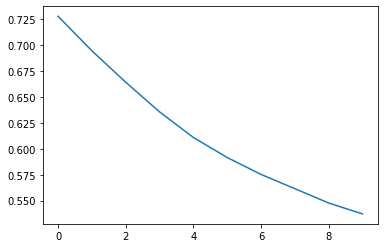

In [ ]:
#pytorch

import matplotlib.pyplot as plt
plt.plot(losses)

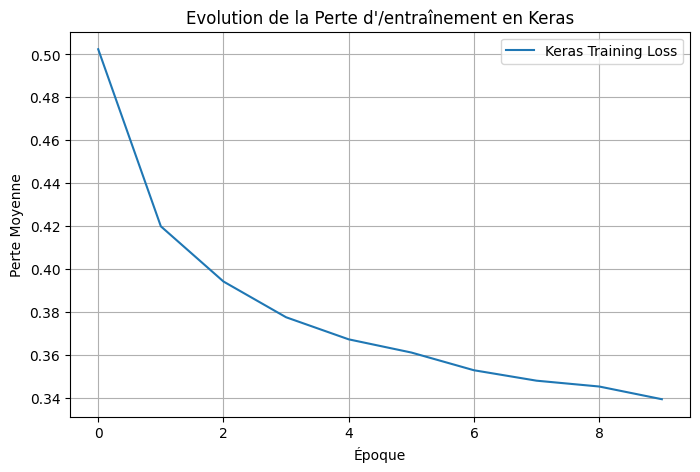

In [ ]:
# keras

import matplotlib.pyplot as plt

# La variable 'losses_keras_per_epoch' a été remplie par la boucle d'entraînement Keras.
# Elle est une liste de flottants.

plt.figure(figsize=(8, 5))
plt.plot(losses_keras_per_epoch, label='Keras Training Loss')
plt.title('Evolution de la Perte d\'/entraînement en Keras')
plt.xlabel('Époque')
plt.ylabel('Perte Moyenne')
plt.grid(True)
plt.legend()
plt.show()

# Alternativement, si vous préférez utiliser le tenseur TensorFlow converti :
# plt.figure(figsize=(8, 5))
# plt.plot(losses_keras_tf.numpy(), label='Keras Training Loss (from tf.Tensor)')
# plt.title('Evolution de la Perte d\'/entraînement en Keras')
# plt.xlabel('Époque')
# plt.ylabel('Perte Moyenne')
# plt.grid(True)
# plt.legend()
# plt.show()


Même si vous avez défini la même graine aléatoire (`tf.random.set_seed(12)` pour Keras et `th.manual_seed(12)` pour PyTorch), il y a plusieurs raisons pour lesquelles la perte initiale peut différer entre les deux frameworks :

*   **Initialisation des poids par défaut** : Bien que les graines aléatoires assurent la reproductibilité *au sein de chaque framework*, les implémentations par défaut des initialiseurs de poids peuvent être différentes entre PyTorch et Keras (TensorFlow). Keras utilise souvent des initialiseurs comme Glorot uniformément pour les poids et des zéros pour les biais par défaut dans ses couches `Dense`, tandis que PyTorch peut avoir ses propres schémas d'initialisation par défaut pour `nn.Linear` et `nn.Embedding`. Ces légères différences dans les valeurs initiales des poids peuvent entraîner des performances de départ différentes.

*   **Précision numérique et opérations** : Les opérations de tenseurs, bien que similaires conceptuellement, peuvent avoir de subtiles différences dans leur implémentation sous-jacente ou leur précision numérique entre les deux bibliothèques. Cela peut affecter la façon dont les embeddings sont générés et sommés, puis comment la sortie finale est calculée.

*   **Ordre des opérations/dépendances** : Même si les graines sont définies, si d'autres opérations aléatoires sont appelées avant l'initialisation des couches, cela pourrait légèrement perturber la séquence des nombres pseudo-aléatoires utilisés pour les poids spécifiques du modèle. Cependant, dans votre cas, vous avez défini la graine juste avant de créer la couche linéaire, ce qui devrait minimiser cela.

En général, une perte initiale plus basse en Keras peut indiquer que son initialisation par défaut des poids a commencé à partir d'un point légèrement plus favorable pour la tâche, ou que les valeurs de ses poids sont plus proches des valeurs optimales.

L'important est la **tendance de la perte au fil des époques** et la performance finale du modèle, plutôt que la valeur absolue de la perte initiale.

## Premières Expériences

*   Effectuer des expériences avec 2000 exemples pour commencer, puis avec toutes les données d'entraînement (réparties équitablement entre les exemples positifs et négatifs).
*   Vous devriez créer des ensembles de développement et de test.
*   Tester différentes paramétrisations du modèle (ici la taille de l'embedding) et l'hyper-paramètre (le taux d'apprentissage) pour chaque configuration.
*   Comparer ces différentes configurations (fonction de perte sur l'entraînement et également la précision de classification).

## Un modèle plus profond

*   Nous pouvons ajouter une couche cachée au classificateur précédent.
*   Faire de même qu'avant avec les différentes configurations.
*   Trouver le bon choix d'hyper-paramètres.